In [6]:
import nlpaug.augmenter.word as naw
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Kalimat asli yang akan diaugmentasi
text = "Saya suka belajar pemrograman Python."

# Augmentasi dengan Synonym Replacement (meningkatkan jumlah kata)
synonym_aug = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=3, aug_p=0.9)
text_synonym = synonym_aug.augment(text)
print("Hasil Synonym Replacement:", text_synonym)

# Augmentasi dengan Random Swap (meningkatkan swap)
swap_aug = naw.RandomWordAug(action="swap", aug_min=1, aug_max=3)
text_augmented = swap_aug.augment(text_synonym)
print("Hasil Kombinasi Synonym Replacement + Random Swap:", text_augmented)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


Hasil Synonym Replacement: ['Saya suka belajar pemrograman Python.']
Hasil Kombinasi Synonym Replacement + Random Swap: ['Saya suka belajar pemrograman Python.']


In [7]:
import nlpaug.augmenter.word as naw

def augment_text(text, n_augmentations=3):
    # Inisialisasi augmenter
    synonym_aug = naw.SynonymAug(aug_src='wordnet')
    swap_aug = naw.RandomWordAug(action="swap")
    
    augmented_texts = []
    
    for _ in range(n_augmentations):
        # Langkah 1: Synonym Replacement
        text_synonym = synonym_aug.augment(text)
        # Langkah 2: Random Swap
        text_augmented = swap_aug.augment(text_synonym)
        augmented_texts.append(text_augmented)
    
    return augmented_texts

# Contoh penggunaan pada satu kalimat
text = "Saya suka belajar pemrograman Python."
augmented_sentences = augment_text(text, n_augmentations=5)

for i, sentence in enumerate(augmented_sentences, 1):
    print(f"Augmented Sentence {i}: {sentence}")


Augmented Sentence 1: ['Suka saya belajar Python pemrograman.']
Augmented Sentence 2: ['Belajar saya suka pemrograman Python.']
Augmented Sentence 3: ['Saya belajar suka Python pemrograman.']
Augmented Sentence 4: ['Suka saya belajar Python pemrograman.']
Augmented Sentence 5: ['Suka saya belajar Python pemrograman.']


In [59]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np

model_name = "sentence-transformers/distiluse-base-multilingual-cased-v2"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sentences = ["Kita harus menyelesaikan tugas ini", "Kita tidak harus menyelesaikan tugas ini"]

sentences_index = [tokenizer.encode(s, add_special_tokens=True) for s in sentences]
features_input_ids = []
features_mask = []
for sent_ids in sentences_index:
    # Truncate if too long
    if len(sent_ids) > 512:
        sent_ids = sent_ids[: 512]
    sent_mask = [1] * len(sent_ids)
    # Padding
    padding_length = 512 - len(sent_ids)
    sent_ids += [0] * padding_length
    sent_mask += [0] * padding_length
    # Length Check
    assert len(sent_ids) == 512
    assert len(sent_mask) == 512

    features_input_ids.append(sent_ids)
    features_mask.append(sent_mask)

features_mask = np.array(features_mask)

batch_input_ids = torch.tensor(features_input_ids, dtype=torch.long)
batch_input_mask = torch.tensor(features_mask, dtype=torch.long)
batch = [batch_input_ids, batch_input_mask]

inputs = {"input_ids": batch[0], "attention_mask": batch[1]}

model.zero_grad()

with torch.no_grad():
    features = model(**inputs)[1]

all_layer_embedding = torch.stack(features).permute(1, 0, 2, 3).cpu().numpy()

def ave_last_hidden(features_mask, all_layer_embedding):
        """
            Average the output from last layer
        """
        unmask_num = np.sum(features_mask, axis=1) - 1 # Not considering the last item
        
        embedding = []
        for i in range(len(unmask_num)):
            sent_len = unmask_num[i]
            hidden_state_sen = all_layer_embedding[i][-1,:,:]
            embedding.append(np.mean(hidden_state_sen[:sent_len,:], axis=0))

        embedding = np.array(embedding)
        return embedding

embedding = ave_last_hidden(features_mask, all_layer_embedding)
similarity = (
    embedding[0].dot(embedding[1])
    / np.linalg.norm(embedding[0])
    / np.linalg.norm(embedding[1])
)
print("The similarity between these two sentences are (from 0-1):", similarity)

sent_1 = sentences[0]
sent_2 = sentences[1]

# Encode sentences
encoding_1 = tokenizer(
    sent_1,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

encoding_2 = tokenizer(
    sent_2,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Zero gradients
model.zero_grad()

# Extract features without gradient computation
with torch.no_grad():
    outputs_1 = model(**encoding_1)
    outputs_2 = model(**encoding_2)

    # Use pooled output if available, else use CLS token
    features_1 = outputs_1.pooler_output if hasattr(outputs_1, 'pooler_output') else outputs_1.last_hidden_state[:, 0, :]
    features_2 = outputs_2.pooler_output if hasattr(outputs_2, 'pooler_output') else outputs_2.last_hidden_state[:, 0, :]

# Compute cosine similarity
cosine_similarities = torch.nn.functional.cosine_similarity(features_1, features_2, dim=1).cpu().numpy()

print(cosine_similarities)

from sentence_transformers import SentenceTransformer, util

# Load SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Get embeddings
embeddings = model.encode(sentences)

# Calculate cosine similarity
cosine_score = util.cos_sim(embeddings[0], embeddings[1])

print(f"Cosine Similarity: {cosine_score.item()}")

The similarity between these two sentences are (from 0-1): 0.861409
[0.90138245]
Cosine Similarity: 0.9554616808891296


In [ ]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

In [ ]:
caug = naw.ContextualWordEmbsAug(
        # option to choose from is "word2vec", "glove" or "fasttext"
        model_path='bert-base-multilingual-cased',

        # options available are insert or substitute
        action='substitute')
# augmented text

text = """saya pergi ke pasar bersama ibu di hari minggu pagi pukul 09.00 menggunakan motor untuk membeli buah-buahan dan sayr"""
augmented_text = caug.augment(text,n=1)
augmented_text[0]

'1 pergi anak kota bersama ibu di 8 minggu pagi saat 09. 45 menggunakan motor burung burung buah - buahan dan sayur'

In [ ]:
from transformers import BertTokenizer, AutoModel
import torch
import torch.nn.functional as F

model_name = 'indobenchmark/indobert-lite-base-p2'
text = 'Mereka sedang belajar di perpustakaan.'
text1 = 'aku sedang di perpustakaan'
model = AutoModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
model.eval()

encoded_input = tokenizer([text, text1], max_length=10, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(**encoded_input)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]

similarity = F.cosine_similarity(cls_embeddings[0], cls_embeddings[1], dim=0)
print(f"Similarity: {similarity.item():.4f}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


{'input_ids': tensor([[    2,   267,   829,   929,    26,  5706, 29948,     3],
        [    2,   304,   829,    26,  5706,     3,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0]])}
Similarity: 0.9412


In [61]:
from transformers import BertTokenizer, AutoModelForMaskedLM
import torch
import random

# Load IndoBERT pretrained model dan tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-lite-base-p2")
model = AutoModelForMaskedLM.from_pretrained("indobenchmark/indobert-lite-base-p2")
model.eval()

def augment_indobert(text, top_k=5):
    words = text.split()
    
    # Pilih satu kata secara acak untuk diganti
    idx_to_replace = random.randint(0, len(words) - 1)
    original_word = words[idx_to_replace]
    
    # Replace dengan [MASK]
    words[idx_to_replace] = '[MASK]'
    masked_text = ' '.join(words)

    # Tokenisasi
    input_ids = tokenizer.encode(masked_text, return_tensors='pt')
    mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1]

    # Prediksi kata untuk [MASK]
    with torch.no_grad():
        output = model(input_ids)
    logits = output.logits
    mask_word_logits = logits[0, mask_index, :]
    top_k_ids = torch.topk(mask_word_logits, top_k, dim=1).indices[0].tolist()

    print(top_k_ids)

    # Buat augmentasi
    augmented_texts = []
    for token_id in top_k_ids:
        new_token = tokenizer.decode([token_id]).strip()
        new_words = words.copy()
        new_words[idx_to_replace] = new_token
        augmented_texts.append(' '.join(new_words))

    return augmented_texts, original_word, masked_text

# Contoh
original = "Saya sedang membaca buku di perpustakaan"
augmented, replaced, masked = augment_indobert(original)
print(f"Original: {original}")
print(f"Masked: {masked}")
print(f"Replaced word: {replaced}")
print("Augmented versions:")
for a in augmented:
    print("-", a)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of AlbertForMaskedLM were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p2 and are newly initialized: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[3908, 9584, 21961, 209, 18000]
Original: Saya sedang membaca buku di perpustakaan
Masked: Saya sedang [MASK] buku di perpustakaan
Replaced word: membaca
Augmented versions:
- Saya sedang ##ombang buku di perpustakaan
- Saya sedang ##ontok buku di perpustakaan
- Saya sedang dipikir buku di perpustakaan
- Saya sedang saya buku di perpustakaan
- Saya sedang memetik buku di perpustakaan


In [61]:
import pandas as pd

df = pd.read_csv("data/clean/cross/train_indo_balanced_combined.csv")

# Number of duplicate 'answer' values (excluding the first occurrence)
num_duplicates = df['answer'].duplicated().sum()
print("Number of duplicate 'answer' values:", num_duplicates)

# Length before removing duplicates
len_before = len(df)
print("Length before removing duplicates:", len_before)

# Drop duplicates based on 'answer', keeping the first
df = df.drop_duplicates(subset='answer', keep='first')

# Length after removing duplicates
len_after = len(df)
print("Length after removing duplicates:", len_after)

df.reset_index(drop=True, inplace=True)
df['score_bin'].value_counts()

Number of duplicate 'answer' values: 31
Length before removing duplicates: 3888
Length after removing duplicates: 3857


score_bin
20-29    412
0-9      408
80-89    396
30-39    386
40-49    384
50-59    383
10-19    377
60-69    375
70-79    375
90-99    361
Name: count, dtype: int64

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857 entries, 0 to 3856
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          3857 non-null   object 
 1   reference_answer  3857 non-null   object 
 2   answer            3857 non-null   object 
 3   score             3857 non-null   int64  
 4   dataset           3857 non-null   object 
 5   dataset_num       3857 non-null   object 
 6   normalized_score  3857 non-null   float64
 7   soal_num          3857 non-null   int64  
 8   kategori          3857 non-null   object 
 9   before            3857 non-null   object 
 10  score_bin         3857 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 331.6+ KB


In [63]:
# pd.set_option('display.max_colwidth', None)
# df = df.loc[(df['before'] != df['answer']) & (df['dataset_num'] == 'analisis_essay-38')]
# df.iloc[5:10][['before', 'answer', 'dataset_num']]

In [64]:
# Simpan panjang sebelum
len_before = len(df)

# Hapus baris yang memenuhi kondisi
df = df.loc[~((df['before'] != df['answer']) & (df['dataset_num'] == 'analisis_essay-38'))]

# Simpan panjang setelah
len_after = len(df)

# Tampilkan hasil
print("Panjang sebelum:", len_before)
print("Panjang sesudah:", len_after)
print("Jumlah baris yang dihapus:", len_before - len_after)

Panjang sebelum: 3857
Panjang sesudah: 3650
Jumlah baris yang dihapus: 207


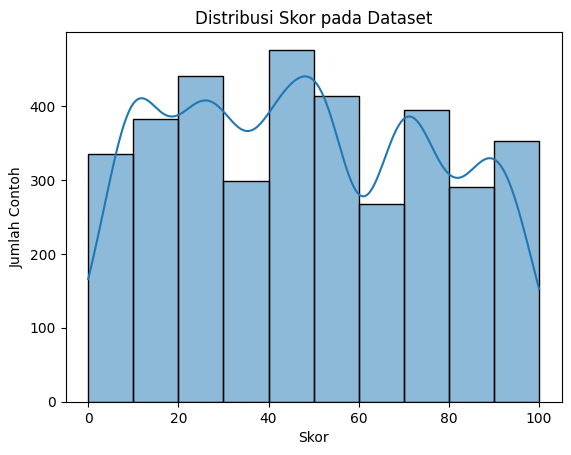

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.histplot(df['score'], bins=10, kde=True)
plt.title('Distribusi Skor pada Dataset')
plt.xlabel('Skor')
plt.ylabel('Jumlah Contoh')
plt.show()

In [68]:
df = df.sort_values('dataset_num').reset_index(drop=True)
df.to_csv("data/clean/cross/train_indo_balanced.csv", index=False)

In [69]:
pd.reset_option('colwidth')
df = pd.read_csv("data/clean/cross/train_indo_balanced.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          3650 non-null   object 
 1   reference_answer  3650 non-null   object 
 2   answer            3650 non-null   object 
 3   score             3650 non-null   int64  
 4   dataset           3650 non-null   object 
 5   dataset_num       3650 non-null   object 
 6   normalized_score  3650 non-null   float64
 7   soal_num          3650 non-null   int64  
 8   kategori          3650 non-null   object 
 9   before            3650 non-null   object 
 10  score_bin         3650 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 313.8+ KB
None


,question,reference_answer,answer,score,dataset,dataset_num,normalized_score,soal_num,kategori,before,score_bin
0,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,untuk pasokan energi,15,analisis_essay,analisis_essay-1,0.15,1,lifestyle,untuk suplay energi,10-19
1,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,memiliki fungsi krusial untuk proses metabolis...,79,analisis_essay,analisis_essay-1,0.79,1,lifestyle,mempunyai peran penting untuk proses metabolis...,70-79
2,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,meningkatkan vitalitas dalam tubuh untuk prose...,35,analisis_essay,analisis_essay-1,0.35,1,lifestyle,menambah energi dalam tubuh untuk proses metab...,30-39
3,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,karbohidrat sebagai sumber energi bagi tubuh m...,19,analisis_essay,analisis_essay-1,0.19,1,lifestyle,karbohidrat sebagai sumber energi bagi tubuh m...,10-19
4,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,sebagai sumber daya,15,analisis_essay,analisis_essay-1,0.15,1,lifestyle,sebagai sumber energi,10-19


## Spesific

In [70]:
import pandas as pd

df = pd.read_csv("data/clean/spesific/train_indo_balanced_combined.csv")

# Number of duplicate 'answer' values (excluding the first occurrence)
num_duplicates = df['answer'].duplicated().sum()
print("Number of duplicate 'answer' values:", num_duplicates)

# Length before removing duplicates
len_before = len(df)
print("Length before removing duplicates:", len_before)

# Drop duplicates based on 'answer', keeping the first
df = df.drop_duplicates(subset='answer', keep='first')

# Length after removing duplicates
len_after = len(df)
print("Length after removing duplicates:", len_after)

df.reset_index(drop=True, inplace=True)
df['score_bin'].value_counts()

Number of duplicate 'answer' values: 29
Length before removing duplicates: 3908
Length after removing duplicates: 3879


score_bin
20-29    414
0-9      411
80-89    399
30-39    387
40-49    387
50-59    384
10-19    379
70-79    377
60-69    377
90-99    364
Name: count, dtype: int64

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3879 entries, 0 to 3878
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          3879 non-null   object 
 1   reference_answer  3879 non-null   object 
 2   answer            3879 non-null   object 
 3   score             3879 non-null   int64  
 4   dataset           3879 non-null   object 
 5   dataset_num       3879 non-null   object 
 6   normalized_score  3879 non-null   float64
 7   before            3879 non-null   object 
 8   score_bin         3879 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 272.9+ KB


In [72]:
# Simpan panjang sebelum
len_before = len(df)

# Hapus baris yang memenuhi kondisi
df = df.loc[~((df['before'] != df['answer']) & (df['dataset_num'] == 'analisis_essay-38'))]

# Simpan panjang setelah
len_after = len(df)

# Tampilkan hasil
print("Panjang sebelum:", len_before)
print("Panjang sesudah:", len_after)
print("Jumlah baris yang dihapus:", len_before - len_after)

Panjang sebelum: 3879
Panjang sesudah: 3735
Jumlah baris yang dihapus: 144


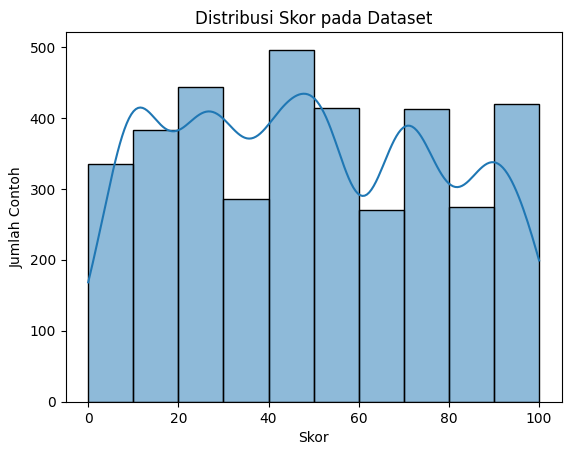

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.histplot(df['score'], bins=10, kde=True)
plt.title('Distribusi Skor pada Dataset')
plt.xlabel('Skor')
plt.ylabel('Jumlah Contoh')
plt.show()

In [74]:
df = df.sort_values('dataset_num').reset_index(drop=True)
df.to_csv("data/clean/spesific/train_indo_balanced.csv", index=False)

In [76]:
pd.reset_option('colwidth')
df = pd.read_csv("data/clean/spesific/train_indo_balanced.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3735 entries, 0 to 3734
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          3735 non-null   object 
 1   reference_answer  3735 non-null   object 
 2   answer            3735 non-null   object 
 3   score             3735 non-null   int64  
 4   dataset           3735 non-null   object 
 5   dataset_num       3735 non-null   object 
 6   normalized_score  3735 non-null   float64
 7   before            3735 non-null   object 
 8   score_bin         3735 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 262.7+ KB
None


,question,reference_answer,answer,score,dataset,dataset_num,normalized_score,before,score_bin
0,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,sumber energi tubuh mengendalikan berat badan ...,54,analisis_essay,analisis_essay-1,0.54,sumber energi tubuh mengendalikan berat badan ...,50-59
1,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,meningkatkan vitalitas dalam tubuh untuk prose...,35,analisis_essay,analisis_essay-1,0.35,menambah energi dalam tubuh untuk proses metab...,30-39
2,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,Kesehat an perkembangan,3,analisis_essay,analisis_essay-1,0.03,kesehetan pertumbuhan,0-9
3,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,Glukosa sebagai sumber tenaga bagi tubuh manusia,19,analisis_essay,analisis_essay-1,0.19,karbohidrat sebagai sumber energi bagi tubuh m...,10-19
4,Jelaskan kegunaan karbohidrat untuk tubuh kita.,fungsi karbohidrat adalah sebagai pemasok ener...,Glukosa memegang peranan krusial untuk proses ...,82,analisis_essay,analisis_essay-1,0.82,karbohidrat mempunyai peran penting untuk pros...,80-89


In [3]:
import pandas as pd

df = pd.read_csv("data/clean/spesific/train_indo_balanced.csv")
df = df[df['answer'] != df['before']]
pd.set_option('max.colwidth', None)
df[['answer', 'before']].head(10)

,answer,before
1,meningkatkan vitalitas dalam tubuh untuk proses metabolisme memperlancar proses pencernaan untuk mengoptimalkan fungsi protein,menambah energi dalam tubuh untuk proses metabolisme memperlancar proses pencernaan untuk mengoptimalkan kerja protein
2,Kesehat an perkembangan,kesehetan pertumbuhan
3,Glukosa sebagai sumber tenaga bagi tubuh manusia,karbohidrat sebagai sumber energi bagi tubuh manusia
4,Glukosa memegang peranan krusial untuk proses metabolisme atau proses yang berfungsi sebagai penyeimbang asam dan basa dalam tubuh glukosa dapat meminimalisir terjadinya ketidaklancaran proses oksidasi lemak fungsi glukosa yang utama adalah sebagai penyuplai energi makanan berglukosa dan serat tinggi dapat membantu memperlancar proses pada pencernaan,karbohidrat mempunyai peran penting untuk proses metabolisme atau proses yang berfungsi sebagai penyeimbang asam dan basa dalam tubuh karbohidrat dapat mencegah terjadinya ketidaksempurnaan proses oksidasi lemak fungsi karbohidrat yang utama adalah sebagai pemasok energi makanan berkarbohidrat dan serat tinggi dapat membantu memperlancar proses pada pencernaan
7,sumber daya tubuh mengendalikan berat badan karbohidrat untuk mencegah penyakit memelihara kesehatan jantung mendukung fungsi pencernaan meningkatkan penyerapan nutrisi mencegah kerusakan jaringan otot mengatur kenaikan kadar gula dalam darah mencukupi kebutuhan fitonutrien mendukung fungsi otak mengatasi kegelisahan,sumber energi tubuh mengendalikan berat badan karbohidrat untuk mencegah penyakit memelihara kesehatan jantung mendukung fungsi pencernaan meningkatkan penyerapan nutrisi mencegah kerusakan jaringan otot mengatur kenaikan kadar gula dalam darah mencukupi kebutuhan fitonutrien mendukung fungsi otak mengatasi kecemasan
8,Glukosa memiliki fungsi krusial untuk proses metabolisme atau proses yang bertugas menyeimbangkan keasaman dan kebasaan dalam tubuh glukosa dapat menghindari terjadinya cacat proses oksidasi lemak fungsi glukosa yang utama adalah sebagai sumber energi makanan yang mengandung karbohidrat dan serat tinggi dapat membantu mempermudah proses pada pencernaan,karbohidrat mempunyai peran penting untuk proses metabolisme atau proses yang berfungsi sebagai penyeimbang asam dan basa dalam tubuh karbohidrat dapat mencegah terjadinya ketidaksempurnaan proses oksidasi lemak fungsi karbohidrat yang utama adalah sebagai pemasok energi makanan berkarbohidrat dan serat tinggi dapat membantu memperlancar proses pada pencernaan
9,menghasilkan badan tidak haus,membuat tubuh tidak lapar
11,sumber daya tubuh mengendalikan berat badan nutrisi untuk mencegah penyakit memelihara kesehatan jantung mendukung fungsi pencernaan meningkatkan penyerapan sari makanan mencegah kerusakan jaringan otot mengatur kenaikan kadar gula dalam darah mencukupi kebutuhan senyawa nutrisi mendukung fungsi otak mengatasi kegelisahan,sumber energi tubuh mengendalikan berat badan karbohidrat untuk mencegah penyakit memelihara kesehatan jantung mendukung fungsi pencernaan meningkatkan penyerapan nutrisi mencegah kerusakan jaringan otot mengatur kenaikan kadar gula dalam darah mencukupi kebutuhan fitonutrien mendukung fungsi otak mengatasi kecemasan
17,tenaga medis rangka dan tubuh,tenaga kesehatan tulang dan tubuh
19,untuk pasokan energi,untuk suplay energi
